In [1]:
%run setup.ipynb
%matplotlib inline
import hapclust
import cartopy; print('cartopy', cartopy.__version__)
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd
import numpy as np
import pickle as peterpickedapickledpepper

cartopy 0.15.1


In [7]:
df_samples = phase1_ar3.df_samples
df_samples.columns

Index(['ox_code', 'src_code', 'sra_sample_accession', 'population', 'country',
       'region', 'contributor', 'contact', 'year', 'm_s', 'sex', 'n_sequences',
       'mean_coverage', 'latitude', 'longitude', 'kt_2la', 'kt_2rb',
       'kdr_1014', 'rdl_296', 'f_roh_100kb', 'count_roh_100kb',
       'sum_roh_100kb', 'pca_3R_free_pc1', 'pca_3R_free_pc2',
       'pca_3R_free_pc3', 'pca_3R_free_pc4', 'pca_3L_free_pc1',
       'pca_3L_free_pc2', 'pca_3L_free_pc3', 'pca_3L_free_pc4', 'pca_2La_pc1',
       'pca_2La_pc2', 'pca_2La_pc3', 'pca_2La_pc4', 'pca_2Rb_pc1',
       'pca_2Rb_pc2', 'pca_2Rb_pc3', 'pca_2Rb_pc4'],
      dtype='object')

In [11]:
df_haplotypes = phase1_ar31.df_haplotypes
df_haplotypes.head()

,label,ox_code,population,label_aug,country,region,sex,m_s,kt_2la,kt_2rb
index,,,,,,,,,,
0,AB0085-Ca,AB0085-C,BFS,"AB0085-Ca [Burkina Faso, Pala, S, F]",Burkina Faso,Pala,F,S,2.0,2.0
1,AB0085-Cb,AB0085-C,BFS,"AB0085-Cb [Burkina Faso, Pala, S, F]",Burkina Faso,Pala,F,S,2.0,2.0
2,AB0087-Ca,AB0087-C,BFM,"AB0087-Ca [Burkina Faso, Bana, M, F]",Burkina Faso,Bana,F,M,2.0,1.0
3,AB0087-Cb,AB0087-C,BFM,"AB0087-Cb [Burkina Faso, Bana, M, F]",Burkina Faso,Bana,F,M,2.0,1.0
4,AB0088-Ca,AB0088-C,BFM,"AB0088-Ca [Burkina Faso, Bana, M, F]",Burkina Faso,Bana,F,M,2.0,0.0


In [14]:
with open('../data/clust_dict.pickle', 'rb') as handle:
    clust_dict = peterpickedapickledpepper.load(handle)

clust_labels = sorted(clust_dict)
clust_labels

['F1', 'F2', 'F3', 'F4', 'F5', 'L1', 'L2', 'S1', 'S2', 'S3', 'S4/5']

In [40]:
tbl_pops = (
    etl
    .wrap([
        ['pop', 'query'],
        ['AOM', 'population == "AOM"'],
        ['BFM', 'population == "BFM"'],
        ['BFS', 'population == "BFS"'],
        ['GNS', 'population == "GNS"'],
        ['CMS_savanna', 'population == "CMS" and (region == "Gado-Badzere" or region == "Zembe-Borongo")'],
        ['CMS_transition', 'population == "CMS" and region == "Daiguene"'],
        ['CMS_forest', 'population == "CMS" and region == "Mayos"'],
        ['GAS', 'population == "GAS"'],
        ['UGS', 'population == "UGS"'],
        ['KES', 'population == "KES"'],
        ['GWA', 'population == "GWA"'],
    ])
    .addfield('latitude', lambda row: df_samples.query(row.query).latitude.mean())
    .addfield('longitude', lambda row: df_samples.query(row.query).longitude.mean())
    .addfield('n_haps', lambda row: len(df_haplotypes.query(row.query)))
)

df_pops = tbl_pops.todataframe()
df_pops = df_pops.set_index('pop')
df_pops

,query,latitude,longitude,n_haps
pop,,,,
AOM,"population == ""AOM""",-8.821000,13.291000,120
BFM,"population == ""BFM""",11.221609,-4.457739,138
BFS,"population == ""BFS""",11.193630,-4.376556,162
GNS,"population == ""GNS""",8.887097,-9.675065,62
CMS_savanna,"population == ""CMS"" and (region == ""Gado-Badze...",5.747000,14.442000,182
CMS_transition,"population == ""CMS"" and region == ""Daiguene""",4.777000,13.844000,166
CMS_forest,"population == ""CMS"" and region == ""Mayos""",4.341000,13.558000,202
GAS,"population == ""GAS""",0.384000,9.455000,112
UGS,"population == ""UGS""",0.770000,34.026000,206


### setup cartopy

In [19]:
crs_lonlat = ccrs.PlateCarree()
ratios = np.asarray([0.5, 0.5])
sum(ratios)

1.0

## calculate haplogroup frequencies across populations

In [25]:
df_pops.index

Index(['AOM', 'BFM', 'BFS', 'GNS', 'CMS_savanna', 'CMS_transition',
       'CMS_forest', 'GAS', 'UGS', 'KES', 'GWA'],
      dtype='object', name='pop')

In [27]:
df_pops.loc['AOM'].query

'population == "AOM"'

In [29]:
#COUNT HAPS - make lists (columns) for each cluster so that we can turn these into a df 

# first set up empty array with 0s
n_pops = len(df_lonlat)
n_outbreaks = len(clust_labels)
frequencies = np.zeros([n_pops, n_outbreaks], dtype=int)

# then loop through clusters
for i, pop in enumerate(df_pops.index):
    pop_query = df_pops.loc[pop].query
    pop_hap_ixs = set(df_haplotypes.query(pop_query).index.values)
    for j, clust_label in enumerate(clust_labels):
        clust_hap_ixs = clust_dict[clust_label]
        isec = pop_hap_ixs.intersection(clust_hap_ixs)
        frequencies[i, j] = len(isec)


# for hg in clust_labels:
#     hg_pops = hap_pops.take(list(clus_dict[hg]))
#     unique, counts = np.unique(hg_pops, return_counts=True)
#     clus_index = list(sorted(clus_dict.keys())).index(hg) #this just gives on of the coordinates for the array
    
#     #then loop through populations present in that haplogroup cluster
#     for u, c in zip(unique, counts):
#         pop_index = pclu.index(u) # this gives the other coordinate
#         arr[pop_index, clus_index] = c
#         #print(clus_index,cov, u, pop_index, c)


In [31]:
#check
frequencies

array([[ 91,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [113,   0,   0,   0,   0,  18,   0,   0,   0,   0,   0],
       [162,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [ 62,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  2,   2,  27,  13,  52,   0,   0,   0,   1,   0,  24],
       [ 16,   6,  17,   6,  55,   0,   0,   0,   4,   0,  20],
       [ 15,   5,   7,   7,  66,   0,   0,   0,   3,   0,  29],
       [  0,   0,   0,  16,  24,   0,   0,   0,  71,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0, 108,   0,  98,   0],
       [  0,   0,   0,   0,   0,   0,  16,   0,   0,  64,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0]])

In [36]:
counts = df_pops.n_haps
counts

pop
AOM               120
BFM               138
BFS               162
GNS                62
CMS_savanna       182
CMS_transition    166
CMS_forest        202
GAS               112
UGS               206
KES                88
GWA                92
Name: n_haps, dtype: int64

In [37]:
# make df for plotting
hap_freq_df = pd.DataFrame(data=frequencies, index=df_pops.index, columns=clust_labels)
hap_freq_df['wildtype'] = counts - hap_freq_df.sum(axis=1).values
hap_freq_df['total'] = counts
hap_freq_df

,F1,F2,F3,F4,F5,L1,L2,S1,S2,S3,S4/5,wildtype,total
pop,,,,,,,,,,,,,
AOM,91,0,0,0,0,0,0,0,0,0,0,29,120
BFM,113,0,0,0,0,18,0,0,0,0,0,7,138
BFS,162,0,0,0,0,0,0,0,0,0,0,0,162
GNS,62,0,0,0,0,0,0,0,0,0,0,0,62
CMS_savanna,2,2,27,13,52,0,0,0,1,0,24,61,182
CMS_transition,16,6,17,6,55,0,0,0,4,0,20,42,166
CMS_forest,15,5,7,7,66,0,0,0,3,0,29,70,202
GAS,0,0,0,16,24,0,0,0,71,0,0,1,112
UGS,0,0,0,0,0,0,0,108,0,98,0,0,206


In [89]:
arr = np.asarray(hap_freq_df
                 .loc[['CMS_savanna', 'CMS_transition', 'CMS_forest']]
                 .iloc[:, :len(clust_labels) + 1])
arr = arr.compress(arr.sum(axis=0) > 0, axis=1)

In [90]:
scipy.stats.chi2_contingency(arr)

(36.98499864366616,
 0.00074161357645049662,
 14,
 array([[ 10.92      ,   4.30181818,  16.87636364,   8.60363636,
          57.24727273,   2.64727273,  24.15636364,  57.24727273],
        [  9.96      ,   3.92363636,  15.39272727,   7.84727273,
          52.21454545,   2.41454545,  22.03272727,  52.21454545],
        [ 12.12      ,   4.77454545,  18.73090909,   9.54909091,
          63.53818182,   2.93818182,  26.81090909,  63.53818182]]))

## build matplotlib pies - use colours from original dendrogram

In [10]:
#from df make 11 slice pie chart proportions (total = 1) for each country
#we need pie colours

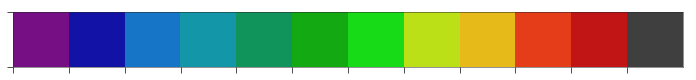

In [38]:
highlight_colors = sns.color_palette('spectral', n_colors=11, desat=0.8)
#add a final colour for wt - see what this looks like
highlight_colors.append((0.250, 0.250, 0.250))
#check
sns.palplot(highlight_colors)

In [39]:
df_pops

,query,latitude,longitude,n_haps
pop,,,,
AOM,"population == ""AOM""",-8.821000,13.291000,120
BFM,"population == ""BFM""",11.221609,-4.457739,138
BFS,"population == ""BFS""",11.193630,-4.376556,162
GNS,"population == ""GNS""",8.887097,-9.675065,62
CMS_savanna,"population == ""CMS"" and (region == ""Gado-Badze...",5.747000,14.442000,182
CMS_transition,"population == ""CMS"" and region == ""Daiguene""",4.777000,13.844000,166
CMS_forest,"population == ""CMS"" and region == ""Mayos""",4.341000,13.558000,202
GAS,"population == ""GAS""",0.384000,9.455000,112
UGS,"population == ""UGS""",0.770000,34.026000,206


In [103]:
df_lonlat = df_pops[['latitude', 'longitude']].copy()
df_lonlat['offset_latitude'] = np.zeros(len(df_lonlat))
df_lonlat['offset_longitude'] = np.zeros(len(df_lonlat))
df_lonlat.loc['BFS'].offset_latitude = 2
df_lonlat.loc['BFS'].offset_longitude = -2
df_lonlat.loc['BFM'].offset_latitude = 2
df_lonlat.loc['BFM'].offset_longitude = 2
df_lonlat.loc['CMS_savanna'].offset_latitude = 3
df_lonlat.loc['CMS_savanna'].offset_longitude = 0.5
df_lonlat.loc['CMS_transition'].offset_latitude = 0.5
df_lonlat.loc['CMS_transition'].offset_longitude = 3
df_lonlat.loc['CMS_forest'].offset_latitude = -3
df_lonlat.loc['CMS_forest'].offset_longitude = 1
df_lonlat.loc['GAS'].offset_latitude = .5
df_lonlat.loc['GAS'].offset_longitude = -3
df_lonlat

,latitude,longitude,offset_latitude,offset_longitude
pop,,,,
AOM,-8.821000,13.291000,0.0,0.0
BFM,11.221609,-4.457739,2.0,2.0
BFS,11.193630,-4.376556,2.0,-2.0
GNS,8.887097,-9.675065,0.0,0.0
CMS_savanna,5.747000,14.442000,3.0,0.5
CMS_transition,4.777000,13.844000,0.5,3.0
CMS_forest,4.341000,13.558000,-3.0,1.0
GAS,0.384000,9.455000,0.5,-3.0
UGS,0.770000,34.026000,0.0,0.0


In [104]:
#for legend
kdr_colors = {
    'F1': highlight_colors[0],
    'F2': highlight_colors[1],
    'F3': highlight_colors[2],
    'F4': highlight_colors[3],
    'F5': highlight_colors[4],
    'L1': highlight_colors[5],
    'L2': highlight_colors[6],
    'S1': highlight_colors[7],
    'S2': highlight_colors[8],
    'S3': highlight_colors[9],
    'S4/5': highlight_colors[10],
    'wt': highlight_colors[11]
}

In [105]:
clust_labels + ['wt']

['F1', 'F2', 'F3', 'F4', 'F5', 'L1', 'L2', 'S1', 'S2', 'S3', 'S4/5', 'wt']

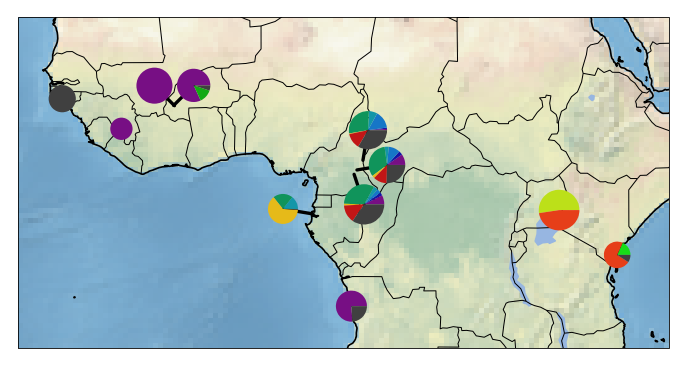

In [107]:
def plot_map():

    #our frame
    extent_lonlat = (-20, 45, -13, 20)

    #plot
    subplot_kw = dict(projection=crs_lonlat)
    fig, ax = plt.subplots(figsize=(7, 7), dpi=120, subplot_kw=subplot_kw)
    ax.coastlines(resolution='50m', linewidth=.2, zorder=1)
    ax.stock_img()
    ax.add_feature(cfeature.BORDERS, lw=.6, zorder=4)
    ax.add_feature(cfeature.LAKES)
    #ax.margins(0)

    #add pies
    for pop, row in df_lonlat.iterrows():
        freqs = hap_freq_df.loc[pop]
        ratios = np.asarray([freqs[k]/freqs['total'] for k in (clust_labels + ['wildtype'])])
        # wedgeprops is used here just to pass the zorder command
        ax.pie(ratios, wedgeprops=dict(zorder=5),  colors=highlight_colors, 
               center=(row.longitude + row.offset_longitude, row.latitude + row.offset_latitude), 
               radius=np.sqrt(hap_freq_df.loc[pop].total * .02))
        
        if row.offset_latitude > 0 or row.offset_longitude > 0:
            ax.plot([row.longitude, row.longitude + row.offset_longitude],
                    [row.latitude, row.latitude + row.offset_latitude], 'k-', lw=2)

    ax.set_extent(extent_lonlat, crs=crs_lonlat)

    # #add lines to BF orgin lonlat
    # ax.plot([-4.413900, -6.413900], [11.206500, 15.206500], 'k-', linewidth=2)
    # ax.plot([-4.413900, -2], [11.206500, 15.206500], 'k-', linewidth=2)

    #legend
    # handles = [mpl.patches.Patch(facecolor=v, edgecolor='k', label=k) for k, v in sorted(kdr_colors.items())]
    # ax.legend(handles=handles, loc='lower left', prop={'size':14})

    #save
    fn = '../artwork/Figure_1b_Map.jpeg'
    fig.savefig(fn, jpeg_quality=100, dpi=300, bbox_inches='tight');

    #save
    fn = '../artwork/Figure_1b_Map.svg'
    fig.savefig(fn, bbox_inches='tight')
    
plot_map()